## 🎯 Expected Goals (xG) Analysis

### Key Research Questions:
- ✅ Which team had the **highest xG** and scored the most goals?
- ✅ Which game had the **highest combined xG** (xG + opp_xG)?
- ✅ Which game had the **biggest difference** between xG and actual goals?
- ✅ Were there any **significant xG trends** or series?
- ✅ How have **average and median xG** changed across seasons?
- ✅ xG comparison **with and without penalties**

### Visualizations:
- 📈 Line plots: xG trends over seasons
- 📊 Bar charts: Teams with biggest xG vs goals difference
- 🔵 Density plot: xG vs actual goals scored
- 📉 Scatter plot: xG overperformance/underperformance

---

In [8]:
import pandas as pd

df = pd.read_parquet('data/serie_a_matches_processed.parquet')

df.tail()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,pkatt,season,team,opp captain,opp sh,opp sot,opp dist,opp fk,opp pk,opp pkatt
1946,2020-09-20,18:00,Serie A,1,Sun,Home,D,1,1,Cagliari,...,0,2020,Sassuolo,João Pedro,8,4,15.9,1,0,0
1947,2020-09-20,15:00,Serie A,1,Sun,Home,W,4,1,Crotone,...,0,2020,Genoa,Alex Cordaz,13,3,18.8,0,0,0
1948,2020-09-20,12:30,Serie A,1,Sun,Home,L,0,2,Napoli,...,0,2020,Parma,Lorenzo Insigne,17,6,19.4,0,0,0
1949,2020-09-19,20:45,Serie A,1,Sat,Home,W,3,0,Roma,...,0,2020,Hellas Verona,Lorenzo Pellegrini,21,4,NaN,0,0,0
1950,2020-09-19,18:00,Serie A,1,Sat,Home,W,1,0,Torino,...,0,2020,Fiorentina,Andrea Belotti,6,3,18.7,1,0,0


## ✅ Implementation (season-based, fully commented)
This section implements every research point above with clear, season-focused analysis and readable visualizations.

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 0) Basic preparation
# -----------------------------
# Make plots readable in notebooks
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 13

# Handle round = 0 (playoffs) by excluding, as requested in earlier notebook
if 'round' in df.columns:
    df = df[df['round'] > 0]

# Exclude season 2025 (still in progress, incomplete data)
df = df[df['season'] != 2025]

# Make sure date is parsed for time series analysis
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Sanity check: how many seasons?
seasons = sorted(df['season'].dropna().unique())
print(f"Seasons available: {seasons}")
print(f"Rows: {len(df):,}")
print(f"Note: Season 2025 excluded (still in progress)")

# Helper: choose a season for focused examples (latest complete season)
season_focus = seasons[-1]
print(f"Using season_focus = {season_focus}")

Seasons available: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Rows: 1,900
Note: Season 2025 excluded (still in progress)
Using season_focus = 2024


### 1️⃣ Which team had the highest xG and scored the most goals?

Top xG team per season:
    season            team  xg_total  goals_total
0     2020        Atalanta      74.5           90
27    2021  Internazionale      81.4           84
46    2022  Internazionale      68.2           71
68    2023  Internazionale      78.1           89
88    2024  Internazionale      66.9           79

Top goals team per season:
    season            team  goals_total  xg_total
0     2020        Atalanta           90      74.5
27    2021  Internazionale           84      81.4
52    2022          Napoli           77      64.7
68    2023  Internazionale           89      78.1
88    2024  Internazionale           79      66.9


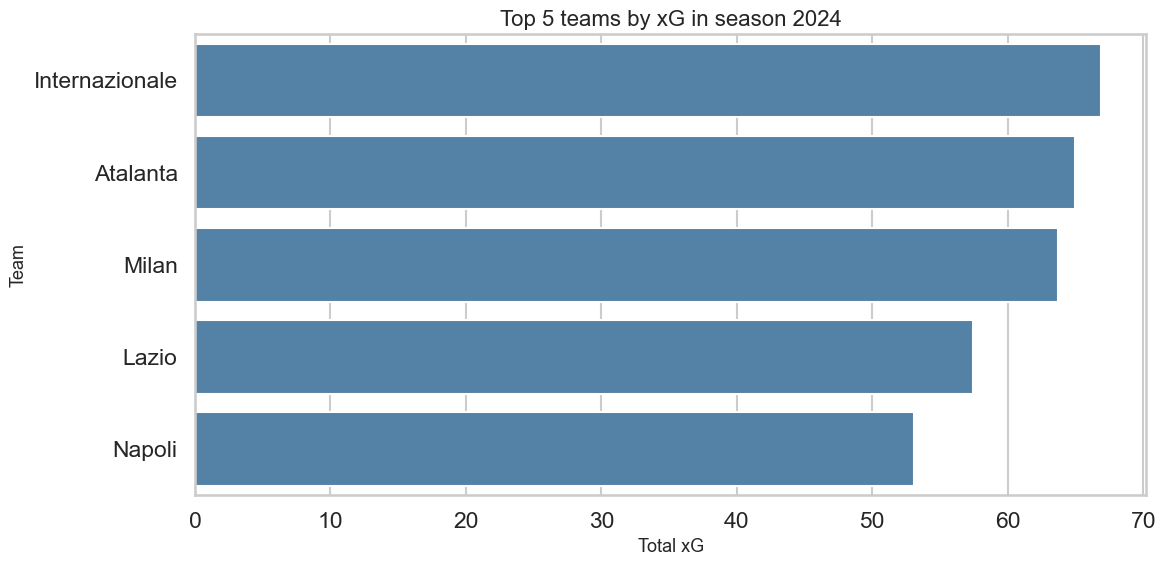

In [14]:
# Approach: aggregate by season and team, accounting for both home and away matches
# Since each row represents one match from home perspective:
# - When team is 'home': use xg, gf, sh, sot, etc.
# - When team is 'away' (opponent): use xga, ga, opp sh, opp sot, etc.

# Home matches aggregation
home_stats = (
    df.groupby(['season', 'team'], as_index=False)
      .agg(
          xg_home=('xg', 'sum'),
          goals_home=('gf', 'sum'),
          matches_home=('team', 'count')
      )
)

# Away matches aggregation (when team is the opponent)
away_stats = (
    df.groupby(['season', 'opponent'], as_index=False)
      .agg(
          xg_away=('xga', 'sum'),
          goals_away=('ga', 'sum'),
          matches_away=('opponent', 'count')
      )
      .rename(columns={'opponent': 'team'})
)

# Combine home and away stats
team_season = home_stats.merge(away_stats, on=['season', 'team'], how='outer').fillna(0)
team_season['xg_total'] = team_season['xg_home'] + team_season['xg_away']
team_season['goals_total'] = team_season['goals_home'] + team_season['goals_away']
team_season['matches'] = team_season['matches_home'] + team_season['matches_away']

# Keep only essential columns
team_season = team_season[['season', 'team', 'xg_total', 'goals_total', 'matches']]

# Top xG team per season
top_xg_by_season = (
    team_season.sort_values(['season', 'xg_total'], ascending=[True, False])
               .groupby('season')
               .head(1)
)

# Top goals team per season
top_goals_by_season = (
    team_season.sort_values(['season', 'goals_total'], ascending=[True, False])
               .groupby('season')
               .head(1)
)

print("Top xG team per season:")
print(top_xg_by_season[['season', 'team', 'xg_total', 'goals_total']])

print("\nTop goals team per season:")
print(top_goals_by_season[['season', 'team', 'goals_total', 'xg_total']])

# Visualization: Top 5 teams by xG for the selected season
season_top5_xg = (
    team_season[team_season['season'] == season_focus]
    .sort_values('xg_total', ascending=False)
    .head(5)
)

plt.figure(figsize=(12, 6))
sns.barplot(data=season_top5_xg, x='xg_total', y='team', color='steelblue')
plt.title(f"Top 5 teams by xG in season {season_focus}")
plt.xlabel("Total xG")
plt.ylabel("Team")
plt.tight_layout()
plt.show()

In [ ]:
season_summary = (
    team_season.sort_values(['xg_total'], ascending=[False])
               .groupby('season')
               .head(5)
)

print("Top 5 Highest xG per season in the last 5 years")
print(season_summary[['season', 'team', 'xg_total', 'goals_total', 'matches']])

Top 5 Highest xG per season in the last 5 years
    season            team  xg_total  goals_total  matches
27    2021  Internazionale      81.4           84       38
68    2023  Internazionale      78.1           89       38
0     2020        Atalanta      74.5           90       38
9     2020        Juventus      74.3           77       38
8     2020  Internazionale      74.2           89       38
11    2020           Milan      70.7           74       38
46    2022  Internazionale      68.2           71       38
12    2020          Napoli      67.8           86       38
88    2024  Internazionale      66.9           79       38
72    2023           Milan      66.2           76       38
32    2021            Roma      65.2           59       38
80    2024        Atalanta      65.0           78       38
52    2022          Napoli      64.7           77       38
92    2024           Milan      63.7           61       38
20    2021        Atalanta      62.3           65       38
74    20

### Overperforming xG (2024 season)

/var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/ipykernel_44236/1756381325.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=season_top_over, x='overperf', y='team',
/var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/ipykernel_44236/1756381325.py:11: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(data=season_top_over, x='overperf', y='team',


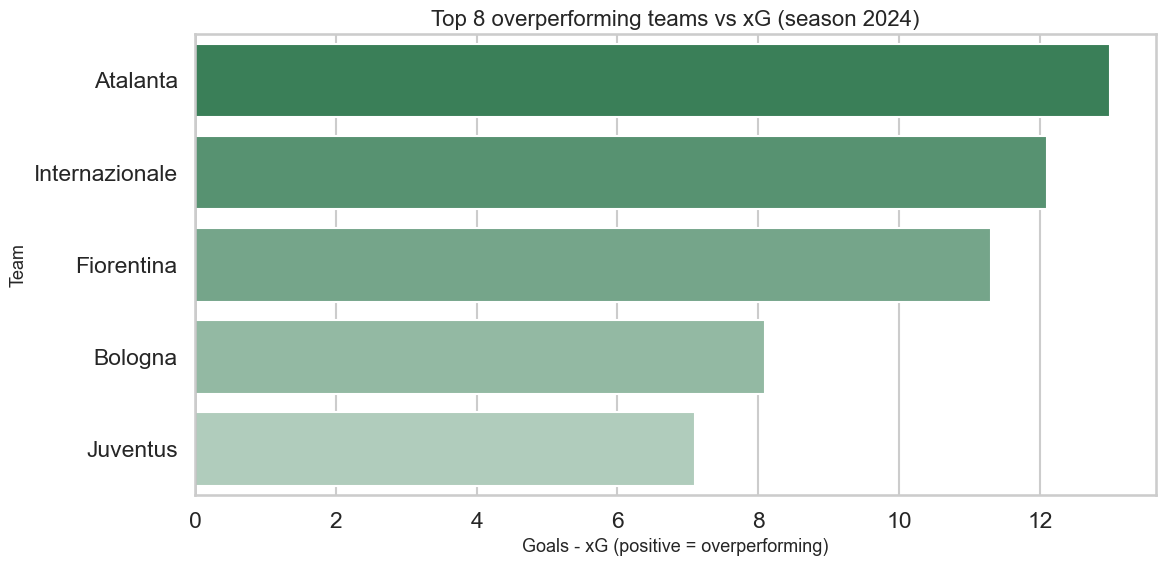


Top overperformers in season 2024:
              team  goals_total  xg_total  overperf
80        Atalanta           78      65.0      13.0
88  Internazionale           79      66.9      12.1
85      Fiorentina           60      48.7      11.3
81         Bologna           57      48.9       8.1
89        Juventus           58      50.9       7.1


In [42]:
team_overperf = team_season.copy()
team_overperf['overperf'] = team_overperf['goals_total'] - team_overperf['xg_total']

season_top_over = (
    team_overperf[team_overperf['season'] == season_focus]
    .sort_values('overperf', ascending=False)
    .head(5)
)

plt.figure(figsize=(12, 6))
sns.barplot(data=season_top_over, x='overperf', y='team', 
            palette=sns.light_palette('seagreen', n_colors=7, reverse=True))
plt.title(f"Top 8 overperforming teams vs xG (season {season_focus})")
plt.xlabel("Goals - xG (positive = overperforming)")
plt.ylabel("Team")
plt.axvline(0, color='black', linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

print(f"\nTop overperformers in season {season_focus}:")
print(season_top_over[['team', 'goals_total', 'xg_total', 'overperf']])

/var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/ipykernel_44236/3659919936.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=season_top_under, x='underperf', y='team',
/var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/ipykernel_44236/3659919936.py:13: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.barplot(data=season_top_under, x='underperf', y='team',


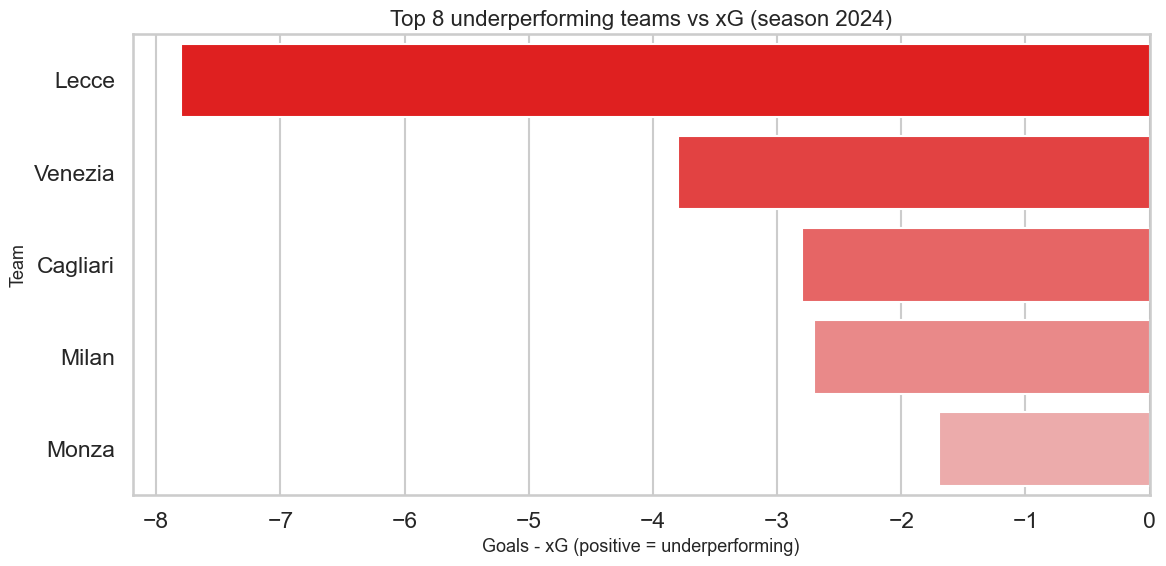


Top underperformers in season 2024:
        team  goals_total  xg_total  underperf
91     Lecce           27      34.8       -7.8
99   Venezia           32      35.8       -3.8
82  Cagliari           40      42.8       -2.8
92     Milan           61      63.7       -2.7
93     Monza           28      29.7       -1.7


In [41]:
# underperforming xG

team_underperf = team_season.copy()
team_underperf['underperf'] = team_underperf['goals_total'] - team_underperf['xg_total']

season_top_under = (
    team_underperf[team_underperf['season'] == season_focus]
			.sort_values('underperf', ascending=True)
    	.head(5)
)

plt.figure(figsize=(12, 6))
sns.barplot(data=season_top_under, x='underperf', y='team', 
            palette=sns.light_palette('red', n_colors=7, reverse=True))
plt.title(f"Top 8 underperforming teams vs xG (season {season_focus})")
plt.xlabel("Goals - xG (positive = underperforming)")
plt.ylabel("Team")
plt.axvline(0, color='black', linestyle='-', linewidth=1)
plt.tight_layout()
plt.show()

print(f"\nTop underperformers in season {season_focus}:")
print(season_top_under[['team', 'goals_total', 'xg_total', 'underperf']])

### 9️⃣ Teams with biggest xG vs goals difference (overperformance)

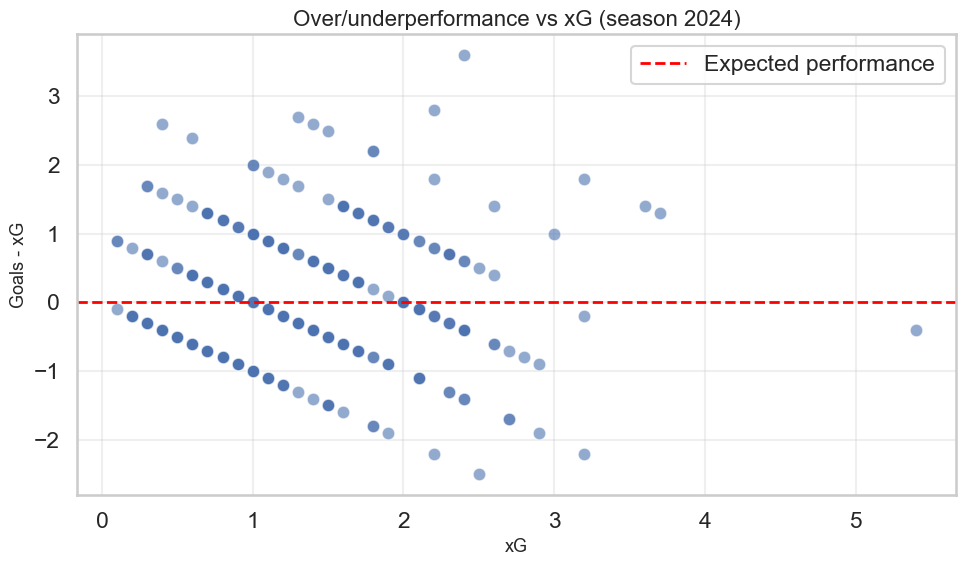

In [24]:
# Overperformance = goals - xG per match
df['goal_minus_xg'] = df['gf'].fillna(0) - df['xg'].fillna(0)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df[df['season'] == season_focus],
    x='xg',
    y='goal_minus_xg',
    alpha=0.6
)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Expected performance')
plt.title(f"Over/underperformance vs xG (season {season_focus})")
plt.xlabel("xG")
plt.ylabel("Goals - xG")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 8️⃣ Over/underperformance scatter plot

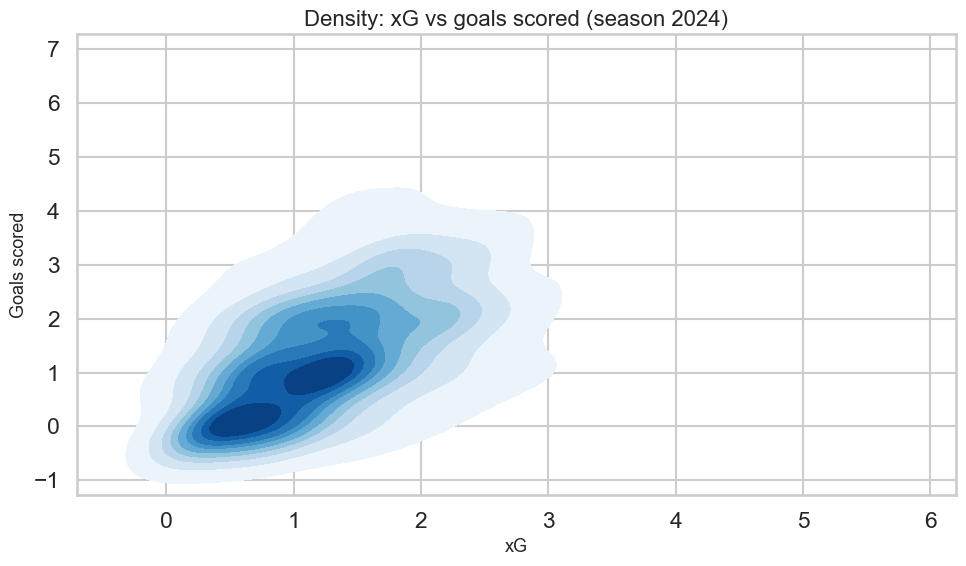

In [25]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df[df['season'] == season_focus],
    x='xg',
    y='gf',
    fill=True,
    cmap='Blues',
    thresh=0.05,
    levels=10
)
plt.title(f"Density: xG vs goals scored (season {season_focus})")
plt.xlabel("xG")
plt.ylabel("Goals scored")
plt.tight_layout()
plt.show()

### 7️⃣ Density plot: xG vs actual goals scored

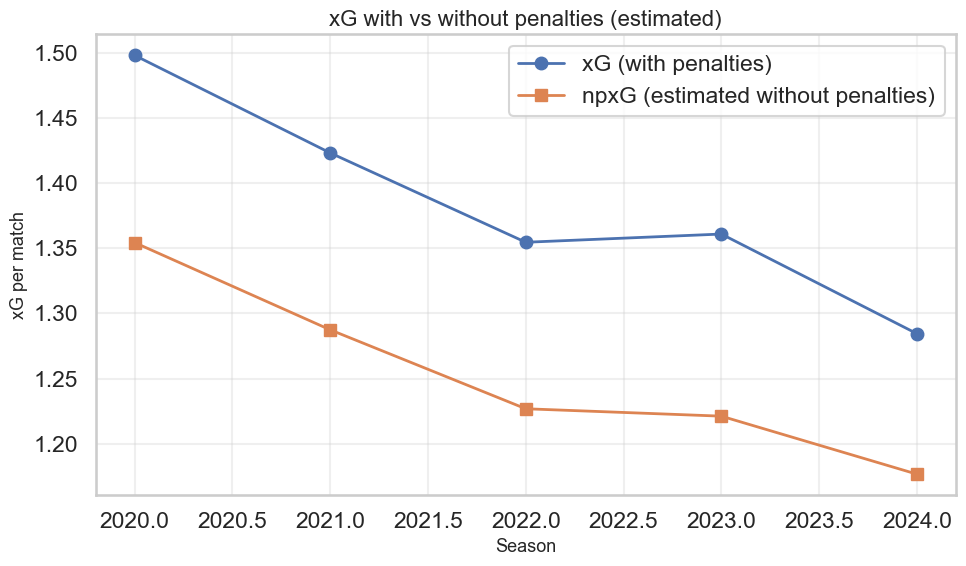


Penalty impact by season:
   season   xg_mean  npxg_mean  penalties_per_match
0    2020  1.498417   1.354474             0.184211
1    2021  1.423421   1.287421             0.178947
2    2022  1.354737   1.226737             0.168421
3    2023  1.361053   1.221053             0.184211
4    2024  1.284474   1.176474             0.142105


In [43]:
# NOTE: Estimating non-penalty xG as: xG - (0.76 * pkatt)
# 0.76 is a common approximate xG value for a penalty
df['npxg_est'] = df['xg'].fillna(0) - 0.76 * df['pkatt'].fillna(0)

season_penalty_xg = (
    df.groupby('season', as_index=False)
      .agg(
          xg_mean=('xg', 'mean'), 
          npxg_mean=('npxg_est', 'mean'),
          penalties_per_match=('pkatt', 'mean')
      )
)

plt.figure(figsize=(10, 6))
plt.plot(season_penalty_xg['season'], season_penalty_xg['xg_mean'], marker='o', label='xG (with penalties)', linewidth=2)
plt.plot(season_penalty_xg['season'], season_penalty_xg['npxg_mean'], marker='s', label='npxG (estimated without penalties)', linewidth=2)
plt.title("xG with vs without penalties (estimated)")
plt.xlabel("Season")
plt.ylabel("xG per match")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nPenalty impact by season:")
print(season_penalty_xg)

### 6️⃣ xG with and without penalties

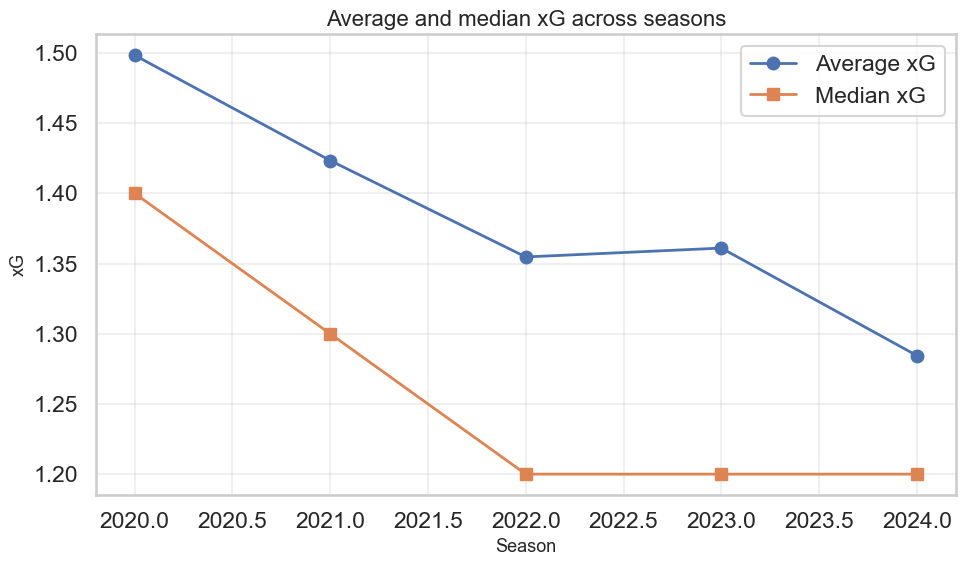


xG statistics by season:
   season   xg_mean  xg_median
0    2020  1.498417        1.4
1    2021  1.423421        1.3
2    2022  1.354737        1.2
3    2023  1.361053        1.2
4    2024  1.284474        1.2


In [44]:
season_xg_stats = (
    df.groupby('season', as_index=False)
      .agg(xg_mean=('xg', 'mean'), xg_median=('xg', 'median'))
)

plt.figure(figsize=(10, 6))
plt.plot(season_xg_stats['season'], season_xg_stats['xg_mean'], marker='o', label='Average xG', linewidth=2)
plt.plot(season_xg_stats['season'], season_xg_stats['xg_median'], marker='s', label='Median xG', linewidth=2)
plt.title("Average and median xG across seasons")
plt.xlabel("Season")
plt.ylabel("xG")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nxG statistics by season:")
print(season_xg_stats)

### 5️⃣ How have average and median xG changed across seasons?

In [45]:
# Compute rolling 5-match xG average for each team
rolling_window = 5

# Sort by date within each season & team, then calculate rolling average
df_sorted = df.sort_values(['season', 'team', 'date']).copy()

# Calculate rolling xG per team
def add_rolling_xg(group):
    group['xg_roll'] = group['xg'].rolling(window=rolling_window, min_periods=3).mean()
    return group

trend_df = df_sorted.groupby(['season', 'team'], group_keys=False).apply(add_rolling_xg)

# Find top rolling xG streaks per season
streaks = (
    trend_df.dropna(subset=['xg_roll'])
            .sort_values(['season', 'xg_roll'], ascending=[True, False])
            .groupby('season')
            .head(5)
            [['season', 'team', 'date', 'xg_roll', 'xg']]
)

print("Top 5 rolling xG streaks per season (window=5):")
print(streaks)

# Visualization: rolling xG trend for the top team in focus season
if not streaks[streaks['season'] == season_focus].empty:
    top_team = streaks[streaks['season'] == season_focus].iloc[0]['team']
    team_trend = trend_df[(trend_df['season'] == season_focus) & (trend_df['team'] == top_team)]

    plt.figure(figsize=(12, 6))
    plt.plot(team_trend['date'], team_trend['xg'], label='Match xG', alpha=0.4, marker='o')
    plt.plot(team_trend['date'], team_trend['xg_roll'], label=f'Rolling xG ({rolling_window} matches)', linewidth=2, color='red')
    plt.title(f"xG trend for {top_team} (season {season_focus})")
    plt.xlabel("Date")
    plt.ylabel("xG")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

KeyError: 'season'

### 4️⃣ Were there any significant xG trends or series?

Match with biggest xG vs goals difference per season:
      season       date            team        opponent  total_goals  \
1812    2020 2021-01-03  Internazionale         Crotone            8   
1421    2021 2021-12-02           Lazio         Udinese            8   
1013    2022 2023-01-15        Atalanta     Salernitana           10   
581     2023 2024-02-10            Roma  Internazionale            6   
346     2024 2024-10-26        Atalanta   Hellas Verona            7   

      total_xg  xg_goal_diff_abs  
1812       3.8               4.2  
1421       3.0               5.0  
1013       3.9               6.1  
581        1.6               4.4  
346        2.6               4.4  


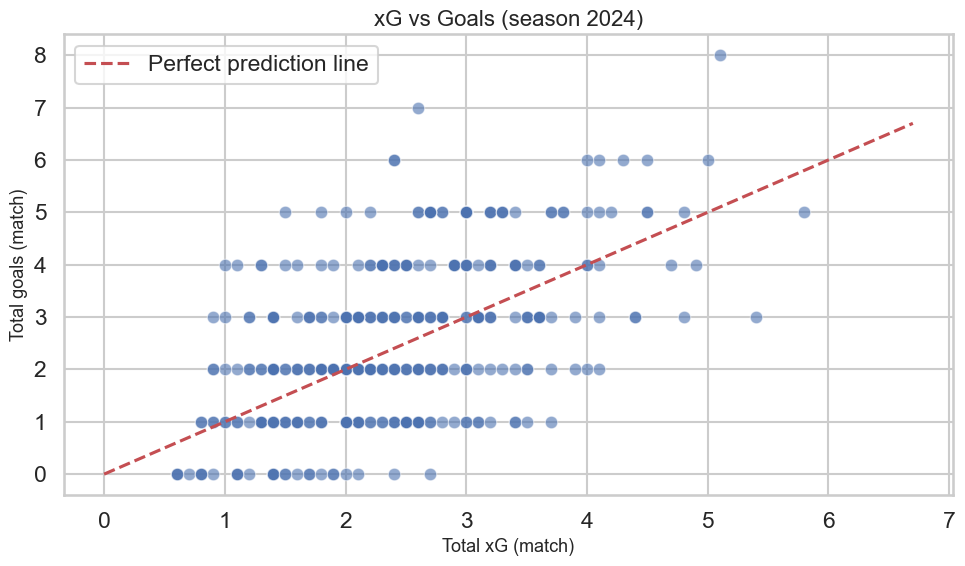

In [46]:
# Compare total goals (gf + ga) vs total xG (xg + xga) per match
df['total_goals'] = df['gf'].fillna(0) + df['ga'].fillna(0)
df['total_xg'] = df['xg'].fillna(0) + df['xga'].fillna(0)
df['xg_goal_diff_abs'] = (df['total_goals'] - df['total_xg']).abs()

max_diff = (
    df.sort_values(['season', 'xg_goal_diff_abs'], ascending=[True, False])
      .groupby('season')
      .head(1)
      [['season', 'date', 'team', 'opponent', 'total_goals', 'total_xg', 'xg_goal_diff_abs']]
)

print("Match with biggest xG vs goals difference per season:")
print(max_diff)

# Visualization: xG vs goals for focused season
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df[df['season'] == season_focus],
    x='total_xg',
    y='total_goals',
    alpha=0.6
)
plt.plot([0, df['total_xg'].max()], [0, df['total_xg'].max()], 'r--', label='Perfect prediction line')
plt.title(f"xG vs Goals (season {season_focus})")
plt.xlabel("Total xG (match)")
plt.ylabel("Total goals (match)")
plt.legend()
plt.tight_layout()
plt.show()

### 3️⃣ Which game had the biggest difference between xG and actual goals?

Match with highest combined xG per season:
      season       date            team  opponent  combined_xg   xg  xga  gf  \
1874    2020 2020-11-22  Internazionale    Torino          6.1  4.0  2.1   4   
1456    2021 2021-11-07         Venezia      Roma          6.7  2.9  3.8   3   
812     2022 2023-06-04        Atalanta     Monza          5.2  4.0  1.2   5   
568     2023 2024-02-17        Atalanta  Sassuolo          5.8  4.2  1.6   3   
267     2024 2024-12-22            Roma     Parma          5.8  5.4  0.4   5   

      ga  
1874   2  
1456   2  
812    2  
568    0  
267    0  


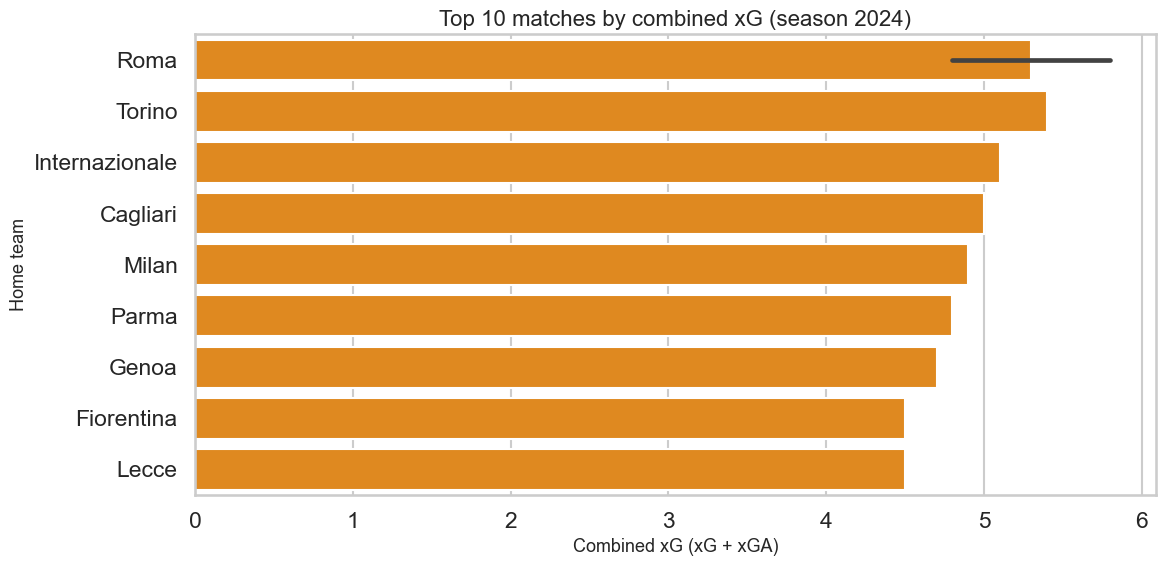

In [47]:
# Combined xG = xG (home) + xGA (away) for that match row.
df['combined_xg'] = df['xg'].fillna(0) + df['xga'].fillna(0)

max_combined = (
    df.sort_values(['season', 'combined_xg'], ascending=[True, False])
      .groupby('season')
      .head(1)
      [['season', 'date', 'team', 'opponent', 'combined_xg', 'xg', 'xga', 'gf', 'ga']]
)

print("Match with highest combined xG per season:")
print(max_combined)

# Visualization for focused season: Top 10 matches by combined xG
season_top10_combined = (
    df[df['season'] == season_focus]
    .sort_values('combined_xg', ascending=False)
    .head(10)
)

plt.figure(figsize=(12, 6))
sns.barplot(data=season_top10_combined, x='combined_xg', y='team', color='darkorange')
plt.title(f"Top 10 matches by combined xG (season {season_focus})")
plt.xlabel("Combined xG (xG + xGA)")
plt.ylabel("Home team")
plt.tight_layout()
plt.show()

### 2️⃣ Which game had the highest combined xG?